In [73]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [74]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [75]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

In [76]:
cad_jpy_df["Price"].max()

137.28

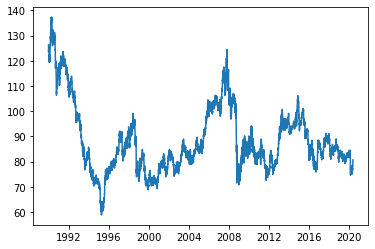

In [77]:
# Plot just the "Price" column from the dataframe:
plt.plot(cad_jpy_df["Price"])
plt.savefig("../Images/cad_jpy_price.png")


**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** 
* Based on the plot above we can see a long-term weakening of the Canadian Dollar respective to the Japanese Yen. We note a large decline in the CAD/JPY exchange rate from 1990 to 1996, reaching a maximum of 1 CAD = 137.28 JPY and falling to a minimum of 1 CAD = 58.88 JPY.
* From 1996 we see the exchange rate rise to 1 CAD = 118.65 JPY in 2007 and rapidly fall during the GFC due to the period of enhanced volatiltiy.
* From 2008 we can note the CAD/JPY has remained relatively consistent, remaining around 1 CAD = 80 to 100 JPY.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [78]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
cad_jpy_noise, cad_jpy_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [79]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_df_hp = pd.concat([cad_jpy_df["Price"], cad_jpy_noise, cad_jpy_trend], axis=1)
cad_jpy_df_hp.head()

,Price,Price_cycle,Price_trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


In [80]:
cad_jpy_df_hp.loc["2017-01-01":"2020-01-01"].mean()

Price          84.633806
Price_cycle     0.001013
Price_trend    84.632793
dtype: float64

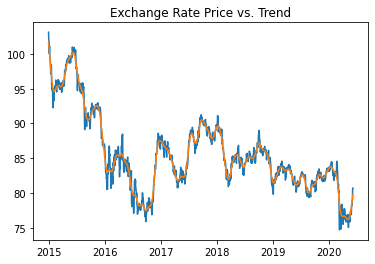

In [81]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
plt.plot(cad_jpy_df_hp.loc["2015-01-01":, ["Price", "Price_trend"]])
plt.title("Exchange Rate Price vs. Trend")
plt.savefig("../Images/cad_jpy_price_trend.png")

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** 
* By smoothing with the HP Filter and plotting the trend against the actual exchange rate price data, we can see that there are short-term fluctuations that deviate around this trend. When the blue line (Price Data) deviates below the orange (Trend Line) we can see this as a sign that the YEN is undervalued and therefore an opportunity to purchase the Japanese YEN with Canadian Dollars
* During this period we can note a long-term pattern of the decline of the CAD/JPY exchange rate from 1 CAD = 103.12 JPY in 2015 to 1 CAD = 74.69 JPY in 2020.
* We can note short-term patterns of a rapid decrease of the CAD/JPY exchange rate from mid 2015 to late 2016. From 2017 to the start of 2020 the exchange rate remained consistent, averaging 1 CAD = 84.36 JPY. 
* From the start of 2020 to the last data point avaliable we can note a rapid decline in the exchange rate as a result of the COVID-19 pandemic.

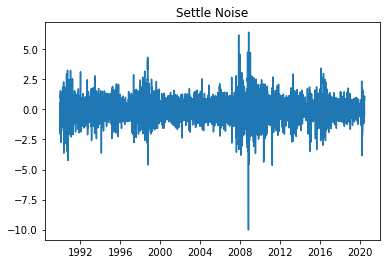

In [82]:
# Plot the Settle Noise
plt.plot(cad_jpy_noise)
plt.title("Settle Noise")
plt.savefig("../Images/cad_jpy_settle_noise.png")

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [83]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


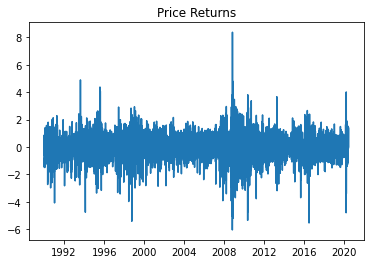

In [84]:
# Plot returns
plt.plot(returns["Price"])
plt.title("Price Returns")
plt.savefig("../Images/cad_jpy_price_returns.png")

In [85]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2, 1))
# Fit the model and assign it to a variable called results
results = model.fit()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [ ]:
# Output model summary results:
ARMA_results.summary()

NameError: name 'ARMA_results' is not defined

In [ ]:
# Plot the 5 Day Returns Forecast
plt.plot(pd.DataFrame(ARMA_results.forecast(steps=5)[0]))
plt.title("5 Day Returns Forecast")
plt.savefig("../Images/cad_jpy_5_day_returns_arma_forecast.png")

NameError: name 'ARMA_results' is not defined

**Question:** Based on the p-value, is the model a good fit?

**Answer:** 
* Based on the p-value of the ARMA model, we can see that the model is overall not a good fit. The p-value for the first AR and MA (both Lag 1) component are less than 0.05 making it statistically significant, indicating we can reject the null hypothesis for ar.L1 and ma.L1. However the p-value for ar.L2 is above 0.05, therefore making it statisticallt insignificant. Therefore we cannot reject the null hypothesis.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
ARIMA_model = ARIMA(cad_jpy_df["Price"], order=(5,1,1))

# Fit the model
ARIMA_results = ARIMA_model.fit()

In [ ]:
# Output model summary results:
ARIMA_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7929
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.898
Date:                Mon, 25 Apr 2022   AIC                          17505.796
Time:                        19:09:16   BIC                          17554.643
Sample:                             0   HQIC                         17522.523
                               - 7929                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4303      0.331      1.299      0.194      -0.219       1.080
ar.L2          0.0178      0.012      1.459      0.145      -0.006       0.042
ar.L3         -0.0118      0.009     -1.313      0.189      -0.029       0.006
ar.L4          0.0110      0.008      1.299      0.194      -0.006       0.028
ar.L5         -0.0191      0.007     -2.706      0.007      -0.033      -0.005
ma.L1         -0.4583      0.332     -1.381      0.167      -1.109       0.192
sigma2         0.5318      0.004    118.418      0.000       0.523       0.541
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9233.72
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

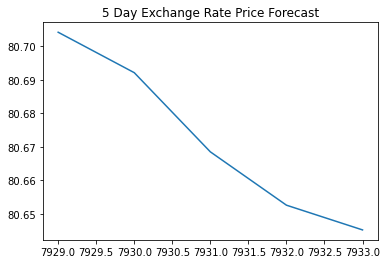

In [ ]:
# Plot the 5 Day Price Forecast
arima_forcast=pd.DataFrame(ARIMA_results.forecast(steps=5))
plt.plot(arima_forcast)
plt.title("5 Day Exchange Rate Price Forecast")
plt.savefig("../Images/cad_jpy_price_arima_forecast.png")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** 
This model forecasts that over the next 5 days the CAD/JPY Exchange rate will have an overall negative trend movement. Meaning 1 Canadian Dollar will equate to less Japanese Yen, indicating the strengthening of JPY relative to the CAD.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [ ]:
import arch as arch_model
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)
# Fit the model
res = model.fit(disp="off")

TypeError: 'module' object is not callable

In [ ]:
# Summarize the model results
res.summary()

NameError: name 'res' is not defined

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [ ]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = GARCH_res.forecast(start=last_day, horizon=forecast_horizon)

NameError: name 'GARCH_res' is not defined

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

NameError: name 'forecasts' is not defined

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

NameError: name 'intermediate' is not defined

In [ ]:
# Plot the final forecast
plt.plot(final)
plt.title("GARCH Volatility Forecast")
plt.savefig("../Images/GARCH_vol_forcast.png")

NameError: name 'final' is not defined

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** 
* Based on the plot above, the forecast for CAD/JPY volatility is expected to rise in the near term

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * Based on this analysis, the YEN will get stronger, so it's a good investment oportunity. 

2. Is the risk of the yen expected to increase or decrease?
    * It is expected that the risk (volatility) will increase, so others factors should be addressed before investment

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * I am not confident in using these models for trading as the models are not a good fit. This is determined by the p-value being greater than 0.05. Therefore the models are statistically insignificant and we cannot reject the null hypothesis 
    * Before trading the CAD/JPY we should always take into account the current economic and political conditions Canadia and Japan.